**Access Across America (AAA)** from [**Accessibility Observatory**](https://ao.umn.edu/) at the University of Minnesota

* **[Available datasets](https://ao.umn.edu/data/datasets)**
* **[Methodology report for transit access](https://ao.umn.edu/research/america/transit/2019/documents/AccessAcrossAmerica-Transit2019-Methodology.pdf)**
* **[Transit data documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

# 1. Setup

In [1]:
from io import BytesIO
import requests

from zipfile import ZipFile

from utils import *

# 2. Prepare data

## 2.1. Download

In [2]:
urls = D(
    transit='https://conservancy.umn.edu/bitstream/handle/11299/256251/Indiana_transit_2021.zip?sequence=17&isAllowed=y',
    bike='https://conservancy.umn.edu/bitstream/handle/11299/256167/Indiana_bike_2021.zip?sequence=12&isAllowed=y')

In [3]:
def get_aaa(urls=urls, overwrite=False):
    outpath = DATA / 'aaa/aaa.parquet'
    if (df := file_check(outpath, overwrite)) is not None: return df
    res = []
    for mode, url in urls.items():
        with ZipFile(BytesIO(requests.get(url).content)) as z:
            for scale, name in D(county='county', tract='census_tract',
                                 bg='block_group').items():
                file = f'Indiana_18_{mode}_{name}_2021.csv'
                z.extract(file, '.')
                df = pd.read_csv(file).astype(D(geoid=str))
                df['thresh'] = (df.threshold / 60).astype(int).astype(str)
                df['access'] = df.weighted_average.astype(np.float32)
                df = df[['geoid', 'thresh', 'access']]
                res.append(df.assign(scale=scale, mode=mode))
                Path(file).unlink()
    df = pd.concat(res).reset_index(drop=True).astype(D(
        geoid=CAT, thresh=CAT, scale=CAT, mode=CAT))
    df.to_parquet(mkfile(outpath))
    return df

aaa = get_aaa().disp()

153,870 rows x 5 cols; Memory: 2.0 MiB


,geoid,thresh,access,scale,mode
,<category>,<category>,<float32>,<category>,<category>
0,18001,5,36.740627,county,transit


# 3. Visualize

In [4]:
zones = gpd.read_parquet(DATA / 'zones/zones_2010.parquet').disp()

6,411 rows x 6 cols; Memory: 1.7 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,county,cbsa,aland,geometry
,<object>,<object>,<object>,<object>,<float32>,<geometry>
0,18001,county,Adams,Decatur,339.026642,"POLYGON ((-9440153.306878 4987988.233537, -944..."


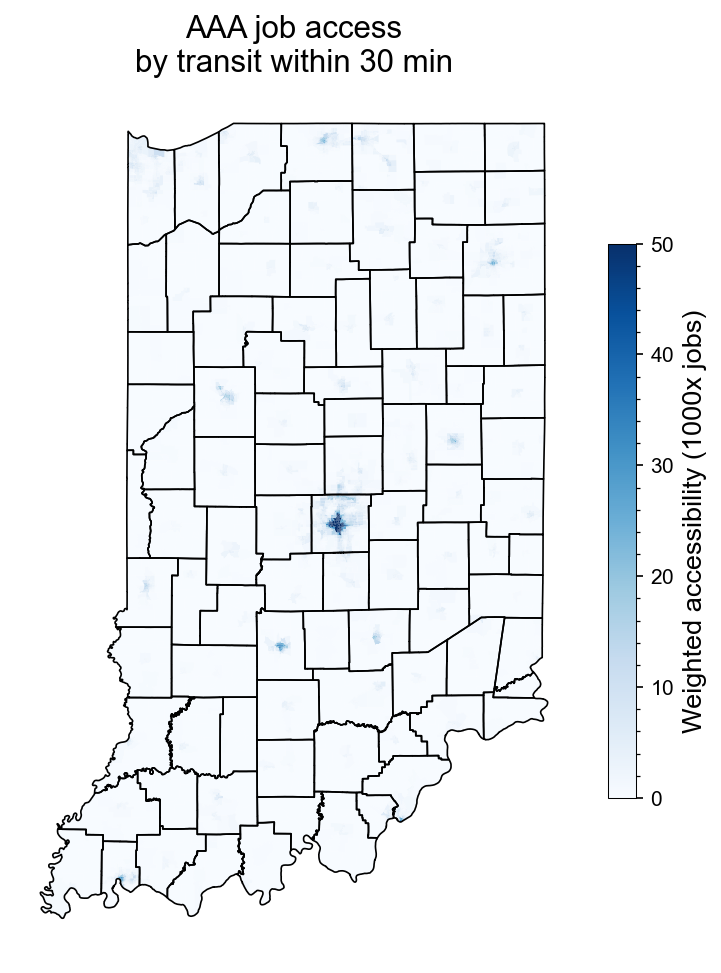

In [11]:
def plot_access(mode, thresh, xs=aaa, zones=zones, counties=[],
                pctile=False, cmap='Blues', vmax=None, size=(6, 12), dpi=150):
    df = xs.query(f'scale=="bg" & mode=="{mode}" & thresh=="{thresh}"')
    df = zones.merge(df).assign(access=lambda df: df.access / 1000)
    if isinstance(counties, list) and len(counties) > 0:
        df = df[df.county.isin(counties)]
    if pctile:
        df.access = df.access.rank(pct=True) * 100
    ax = pplot(size=size, dpi=dpi, axoff=1,
               title=f'AAA job access\nby {mode} within {thresh} min')
    cbar_label = 'Weighted accessibility (1000x jobs)'
    df.plot(column='access', cmap=cmap, lw=0.2,
            legend=True, ax=ax, vmin=0, vmax=100 if pctile else vmax,
            legend_kwds=D(shrink=0.4, label=cbar_label))
    df.dissolve('county').plot(ax=ax, fc='none', ec='k', lw=0.8)

plot_access('transit', 30, vmax=50)

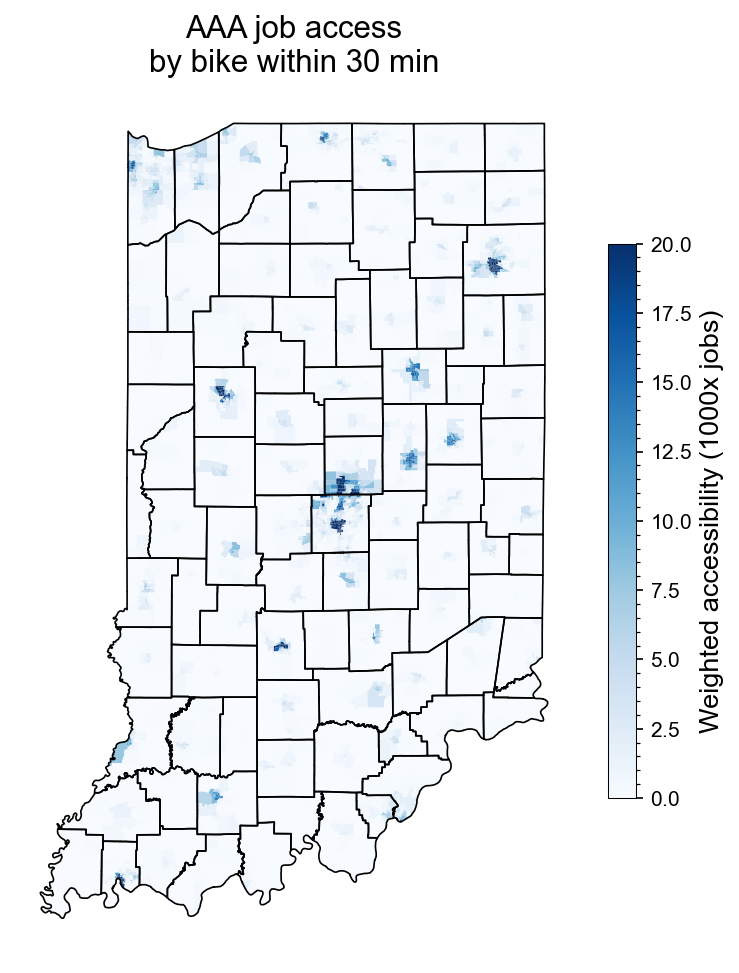

In [6]:
plot_access('bike', 30, vmax=20)

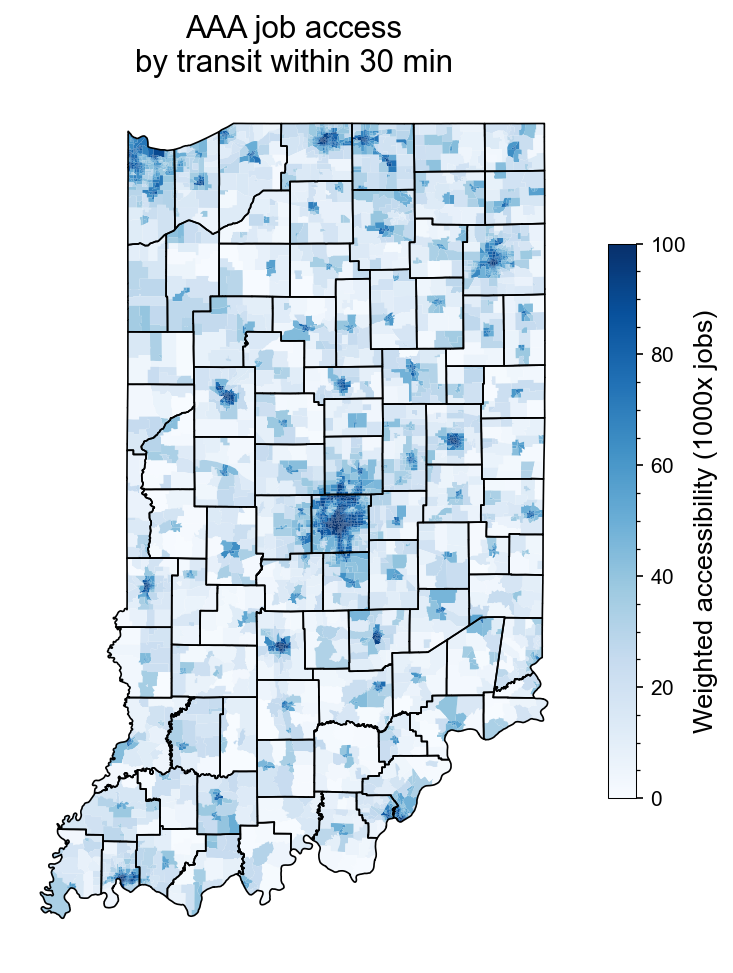

In [13]:
plot_access('transit', 30, pctile=True)

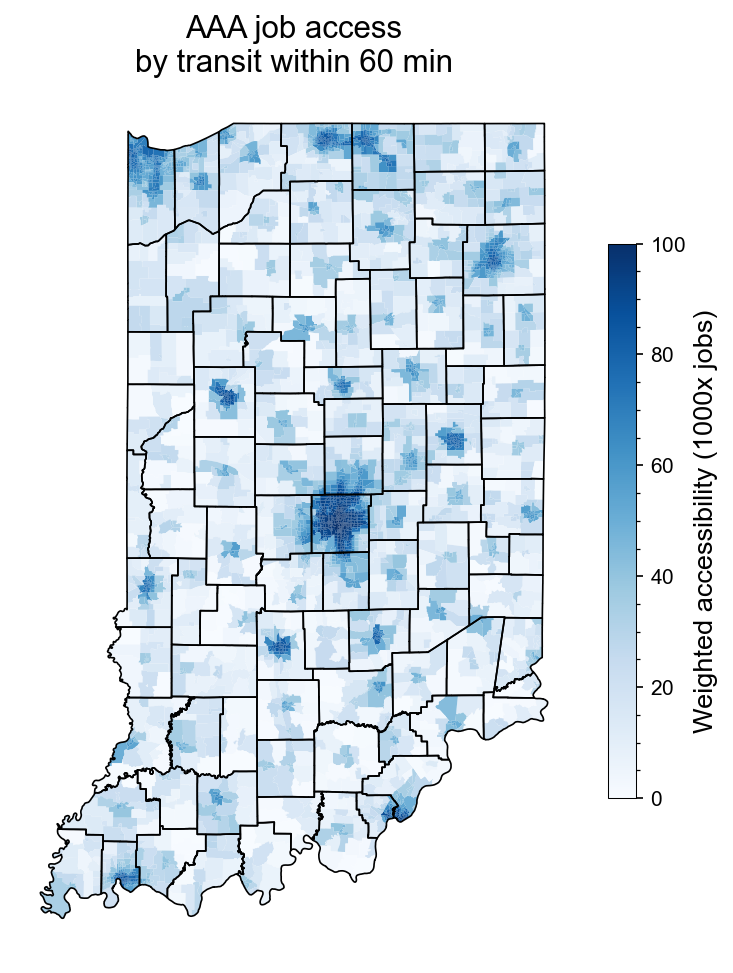

In [16]:
plot_access('transit', 60, pctile=True)

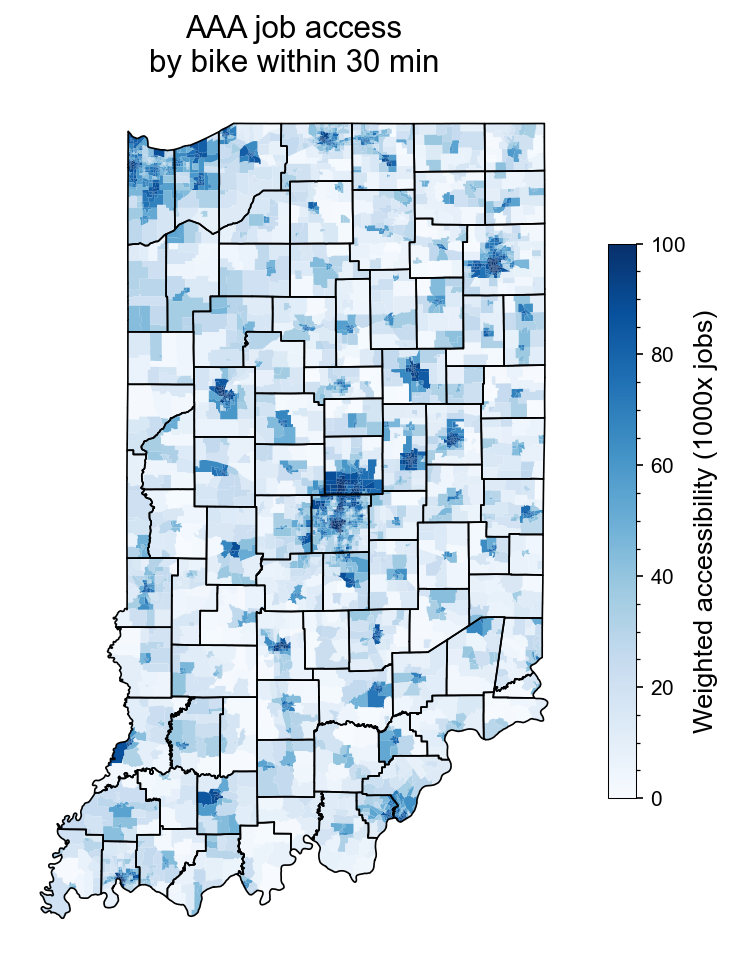

In [ ]:
plot_access('bike', 30, pctile=True)

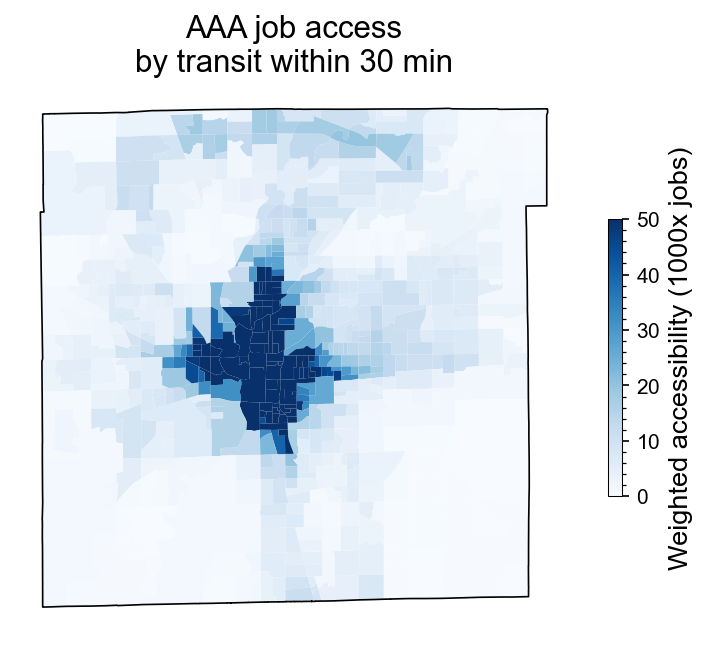

In [7]:
plot_access('transit', 30, vmax=50, counties=['Marion'], size=(6, 6))

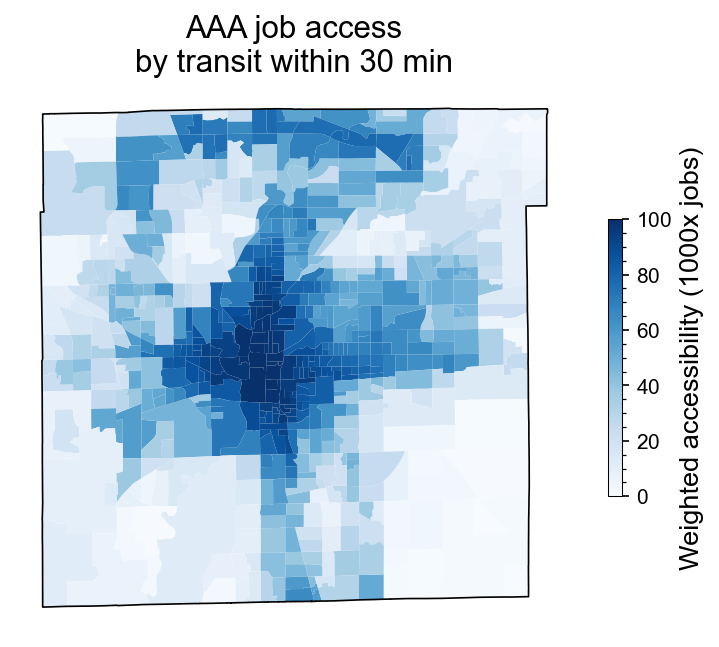

In [14]:
plot_access('transit', 30, pctile=True, counties=['Marion'], size=(6, 6))

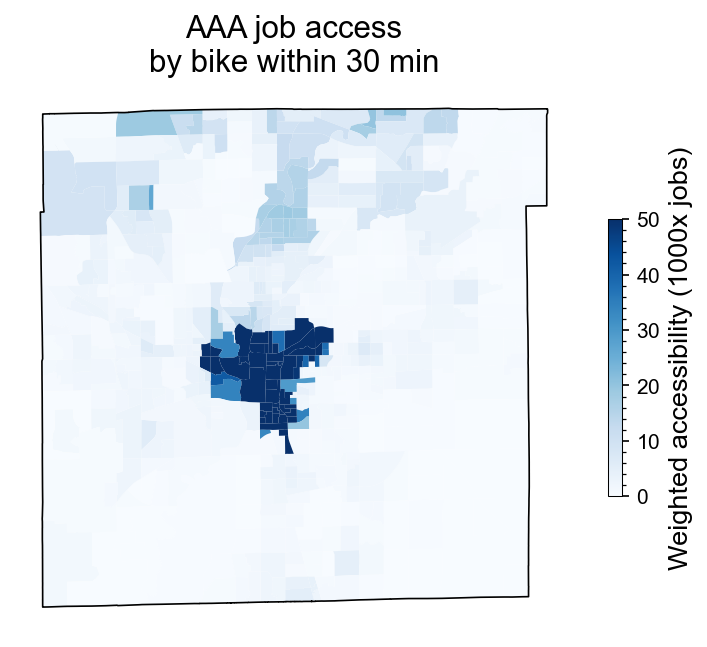

In [8]:
plot_access('bike', 30, vmax=50, counties=['Marion'], size=(6, 6))

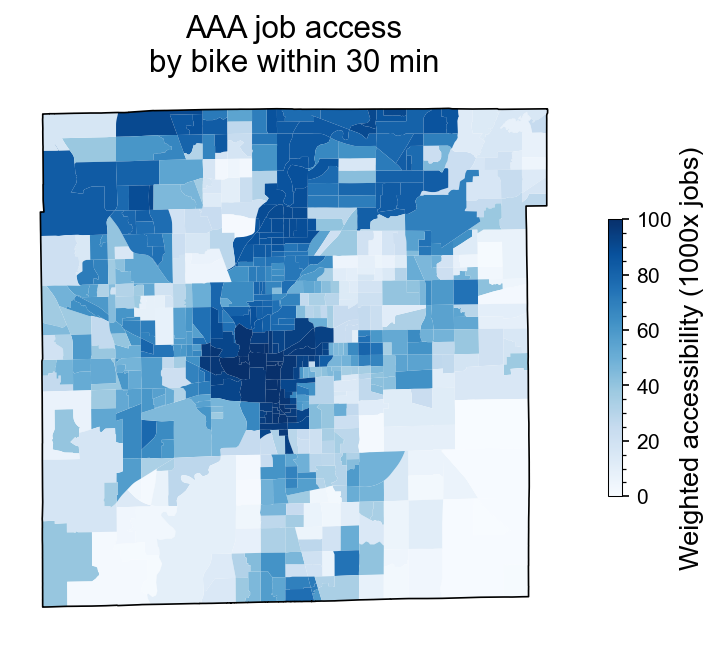

In [15]:
plot_access('bike', 30, pctile=1, counties=['Marion'], size=(6, 6))